In [1]:
import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd 
import os
import re
import numpy as np

torch.manual_seed(1234)

In [2]:
#read data

covid_cumulative_cases = pd.read_csv('../input/sidrv-data-organnize/covid_real_data_cumulative_cases.csv', delimiter=',') #in the form of [t,S,I,D,R。。。]
covid_cumulative_cases.columns = ['t', 'cumulative_susceptible','cumulative_infected', 'cumulative_dead', 'cumulative_recovered','cumulative_active'] #rename columns
covid_cumulative_cases['t'] = covid_cumulative_cases['t'].astype(float)
covid_cumulative_cases

,t,cumulative_susceptible,cumulative_infected,cumulative_dead,cumulative_recovered,cumulative_active
0,0.0,327237003.0,461661.0,22362,67139.0,211835.0
1,1.0,327200682.0,473795.0,23909,78924.0,222690.0
2,2.0,327155949.0,491601.0,26236,85408.0,240806.0
3,3.0,327113447.0,512342.0,28721,91501.0,253989.0
4,4.0,327075093.0,533213.0,33322,96735.0,261637.0
...,...,...,...,...,...,...
739,739.0,247138090.0,79871231.0,990679,0.0,0.0
740,740.0,247048432.0,79960327.0,991241,0.0,0.0
741,741.0,247028770.0,79979927.0,991303,0.0,0.0
742,742.0,247015786.0,79992888.0,991326,0.0,0.0


In [3]:
cumulative_susceptible = []
cumulative_infected = [] 
cumulative_dead = []
cumulative_recovered = []
timesteps = []
# set the dataset here !
DAYS = 310
timestep = 0
ratio = 0.8

d1 = covid_cumulative_cases['cumulative_susceptible'][:DAYS]
d2 = covid_cumulative_cases['cumulative_infected'][:DAYS]
d3 = covid_cumulative_cases['cumulative_dead'][:DAYS]
d4 = covid_cumulative_cases['cumulative_recovered'][:DAYS]
d5 = covid_cumulative_cases['t'][:DAYS]

for item in range(len(d5)):
    try:
        if item%timestep == 0:
            cumulative_susceptible.append(d1[item])
            cumulative_infected.append(d2[item]) 
            cumulative_dead.append(d3[item])
            cumulative_recovered.append(d4[item])
            timesteps.append(d5[item])

    except:
            cumulative_susceptible.append(d1[item])
            cumulative_infected.append(d2[item]) 
            cumulative_dead.append(d3[item])
            cumulative_recovered.append(d4[item])
            timesteps.append(d5[item])
            
datasize = len(timesteps)
trainsize = int(datasize * ratio)
print('datasize is:',datasize)
print('trainsize is:',trainsize)

datasize is: 310
trainsize is: 248


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  app.launch_new_instance()


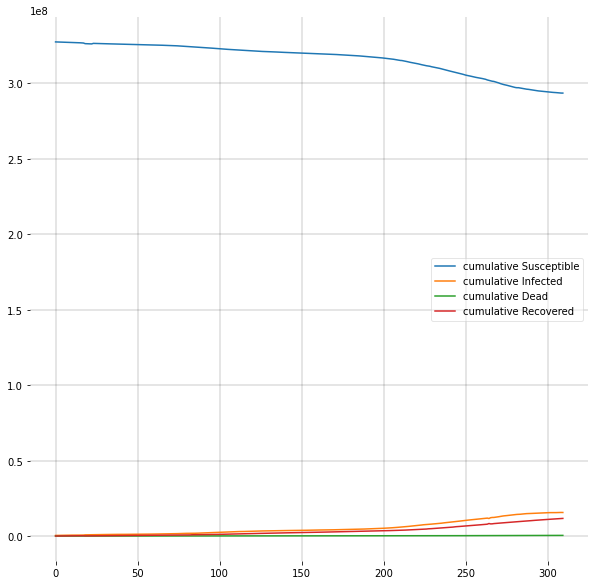

In [4]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')

#plt.plot(covid_cumulative_cases['cumulative_susceptible'][:DAYS], label = 'cumulative Susceptible')
#plt.plot(covid_cumulative_cases['cumulative_infected'][:DAYS], label = 'cumulative Infected')
#plt.plot(covid_cumulative_cases['cumulative_dead'][:DAYS], label = 'cumulative Dead')
#plt.plot(covid_cumulative_cases['cumulative_recovered'][:DAYS], label = 'cumulative Recovered')

plt.plot(cumulative_susceptible, label = 'cumulative Susceptible')
plt.plot(cumulative_infected, label = 'cumulative Infected')
plt.plot(cumulative_dead, label = 'cumulative Dead')
plt.plot(cumulative_recovered, label = 'cumulative Recovered')

ax.grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show();

In [5]:
%%time

PATH = 'covid_real_data_cumulative_cases' 

class DINN(nn.Module):
    def __init__(self, t, S_data, I_data, D_data, R_data): #[t,S,I,D,R]
        super(DINN, self).__init__()
        self.N = 340e6 #population size
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 
        self.S = torch.tensor(S_data)
        self.I = torch.tensor(I_data)
        self.D = torch.tensor(D_data)
        self.R = torch.tensor(R_data)

        self.losses = []
        self.errors = []
        self.save = 3 #which file to save to

        self.alpha_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #0.191
        self.beta_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #0.05
        self.gamma_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #0.0294
        
        #find values for normalization
        self.S_max = max(self.S)
        self.I_max = max(self.I)
        self.D_max = max(self.D)
        self.R_max = max(self.R)
        self.S_min = min(self.S)
        self.I_min = min(self.I)
        self.D_min = min(self.D)
        self.R_min = min(self.R)

        #unnormalize
        self.S_hat = (self.S - self.S_min) / (self.S_max - self.S_min)
        self.I_hat = (self.I - self.I_min) / (self.I_max - self.I_min)
        self.D_hat = (self.D - self.D_min) / (self.D_max - self.D_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)

        #matrices (x4 for S,I,D,R) for the gradients
        self.m1 = torch.zeros((len(self.t), 4)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 4)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 4)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 4)); self.m4[:, 3] = 1

        #NN
        self.net_sidr = self.Net_sidr()
        self.params = list(self.net_sidr.parameters())
        self.params.extend(list([self.alpha_tilda, self.beta_tilda, self.gamma_tilda]))

    #force parameters to be in a range
    @property
    def alpha(self):
        return torch.tanh(self.alpha_tilda)

    @property
    def beta(self):
        return torch.tanh(self.beta_tilda)
    
    @property
    def gamma(self):
        return torch.tanh(self.gamma_tilda)


    #nets
    class Net_sidr(nn.Module): # input = [t]
        def __init__(self):
            super(DINN.Net_sidr, self).__init__()
            self.fc1=nn.Linear(1, 20) 
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.out=nn.Linear(20, 4) #outputs S, I, D, R

        def forward(self, t_batch):
            sidr=F.relu(self.fc1(t_batch))
            sidr=F.relu(self.fc2(sidr))
            sidr=F.relu(self.fc3(sidr))
            sidr=F.relu(self.fc4(sidr))
            sidr=F.relu(self.fc5(sidr))
            sidr=F.relu(self.fc6(sidr))
            sidr=F.relu(self.fc7(sidr))
            sidr=F.relu(self.fc8(sidr))
            sidr=self.out(sidr)
            return sidr
            
    def net_f(self, t_batch):
        sidr_hat = self.net_sidr(t_batch)

        S_hat, I_hat, D_hat, R_hat = sidr_hat[:,0], sidr_hat[:,1], sidr_hat[:,2], sidr_hat[:,3]

        #S_t
        sidr_hat.backward(self.m1, retain_graph=True)
        
        S_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #I_t
        sidr_hat.backward(self.m2, retain_graph=True)
        
        I_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #D_t
        sidr_hat.backward(self.m3, retain_graph=True)
        
        D_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #R_t
        sidr_hat.backward(self.m4, retain_graph=True)
        
        R_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #unnormalize
        S = self.S_min + (self.S_max - self.S_min) * S_hat
        I = self.I_min + (self.I_max - self.I_min) * I_hat
        D = self.D_min + (self.D_max - self.D_min) * D_hat      
        R = self.R_min + (self.R_max - self.R_min) * R_hat

        f1_hat = S_hat_t - (-(self.alpha / self.N) * S * I)  / (self.S_max - self.S_min)
        f2_hat = I_hat_t - ((self.alpha / self.N) * S * I - self.beta * I - self.gamma * I ) / (self.I_max - self.I_min)
        f3_hat = D_hat_t - (self.gamma * I) / (self.D_max - self.D_min)
        f4_hat = R_hat_t - (self.beta * I ) / (self.R_max - self.R_min)


        return f1_hat, f2_hat, f3_hat, f4_hat, S_hat, I_hat, D_hat, R_hat
    
    def load(self):
      # Load checkpoint
      try:
        checkpoint = torch.load(PATH + str(self.save)+'.pt') 
        print('\nloading pre-trained model...')
        self.load_state_dict(checkpoint['model'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler'])
        epoch = checkpoint['epoch']
         
        self.losses = checkpoint['losses']
         

      except RuntimeError :
          print('changed the architecture, ignore')
          pass
      except FileNotFoundError:
          pass
    
    def calculate_RSM(data,pred,size):
        torch.mean(torch.square(data[:size] - pred[:size]))
        
    def train(self, n_epochs):
      #try loading
      self.load()

      #train
      print('\nstarting training...\n')
      
      for epoch in range(n_epochs):
        #lists to hold the output (maintain only the final epoch)
        S_pred_list = []
        I_pred_list = []
        D_pred_list = []
        R_pred_list = []

         
        f1, f2, f3, f4, S_pred, I_pred, D_pred, R_pred = self.net_f(self.t_batch)
        self.optimizer.zero_grad()

        S_pred_list.append(self.S_min + (self.S_max - self.S_min) * S_pred) 
        I_pred_list.append(self.I_min + (self.I_max - self.I_min) * I_pred)
        D_pred_list.append(self.D_min + (self.D_max - self.D_min) * D_pred)
        R_pred_list.append(self.R_min + (self.R_max - self.R_min) * R_pred)
    
        loss = (torch.mean(torch.square(self.S_hat[:trainsize] - S_pred[:trainsize]))+ 
                torch.mean(torch.square(self.I_hat[:trainsize] - I_pred[:trainsize]))+
                torch.mean(torch.square(self.D_hat[:trainsize] - D_pred[:trainsize]))+
                torch.mean(torch.square(self.R_hat[:trainsize] - R_pred[:trainsize]))+
                torch.mean(torch.square(f1[:trainsize]))+
                torch.mean(torch.square(f2[:trainsize]))+
                torch.mean(torch.square(f3[:trainsize]))+
                torch.mean(torch.square(f4[:trainsize]))
                ) 
        error = (torch.mean(torch.square(self.S_hat[trainsize:] - S_pred[trainsize:]))+ 
                torch.mean(torch.square(self.I_hat[trainsize:] - I_pred[trainsize:]))+
                torch.mean(torch.square(self.D_hat[trainsize:] - D_pred[trainsize:]))+
                torch.mean(torch.square(self.R_hat[trainsize:] - R_pred[trainsize:]))+
                torch.mean(torch.square(f1[trainsize:]))+
                torch.mean(torch.square(f2[trainsize:]))+
                torch.mean(torch.square(f3[trainsize:]))+
                torch.mean(torch.square(f4[trainsize:]))
                ) 

        #error.backward(retain_graph=True)
        loss.backward()
        self.optimizer.step()
        self.scheduler.step() 
         
         

        self.losses.append(loss.item())
        self.errors.append(error.item())

        #if epoch % 1000 == 0:          
          #print('\nEpoch ', epoch)

        #loss + model parameters update
        if epoch % 5000 == 0:
          #checkpoint save every 100 epochs if the loss is lower
          print('\nSaving model... Loss is:', loss,'error is:',error)
          torch.save({
              'epoch': epoch,
              'model': self.state_dict(),
              'optimizer_state_dict': self.optimizer.state_dict(),
              'scheduler': self.scheduler.state_dict(),
              #'loss': loss,
              'losses': self.losses,
              'error':self.errors
              }, PATH + str(self.save)+'.pt')
          if self.save % 2 > 0: #its on 3
            self.save = 2 #change to 2
          else: #its on 2
            self.save = 3 #change to 3

          print('epoch: ', epoch)
        

      return S_pred_list, I_pred_list, D_pred_list, R_pred_list

CPU times: user 46 µs, sys: 9 µs, total: 55 µs
Wall time: 59.6 µs


In [6]:
%%time

dinn = DINN(timesteps, cumulative_susceptible, cumulative_infected, cumulative_dead, cumulative_recovered) #in the form of [t,S,I,D,R]

learning_rate = 1e-5
optimizer = optim.Adam(dinn.params, lr = learning_rate)
dinn.optimizer = optimizer

 
scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=1000, mode="exp_range", gamma=0.85, cycle_momentum=False)

dinn.scheduler = scheduler

try: 
  S_pred_list, I_pred_list, D_pred_list, R_pred_list = dinn.train(500000) #train
except EOFError:
  if dinn.save == 2:
    dinn.save = 3
    S_pred_list, I_pred_list, D_pred_list, R_pred_list = dinn.train(500000) #train
  elif dinn.save == 3:
    dinn.save = 2
    S_pred_list, I_pred_list, D_pred_list, R_pred_list = dinn.train(500000) #train


starting training...


Saving model... Loss is: tensor(0.9425, dtype=torch.float64, grad_fn=<AddBackward0>) error is: tensor(2.4179, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  0

Saving model... Loss is: tensor(0.1642, dtype=torch.float64, grad_fn=<AddBackward0>) error is: tensor(1.5041, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  5000

Saving model... Loss is: tensor(0.0791, dtype=torch.float64, grad_fn=<AddBackward0>) error is: tensor(1.0759, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  10000

Saving model... Loss is: tensor(0.0761, dtype=torch.float64, grad_fn=<AddBackward0>) error is: tensor(0.9754, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  15000

Saving model... Loss is: tensor(0.0715, dtype=torch.float64, grad_fn=<AddBackward0>) error is: tensor(0.8519, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  20000

Saving model... Loss is: tensor(0.0442, dtype=torch.float64, grad_fn=<AddBackward0>) error is: tensor(0.5281, dtype=torch.float64, 

Text(0, 0.5, 'RSS')

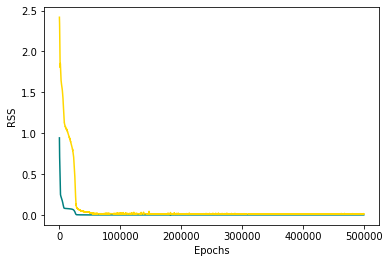

In [7]:
plt.plot(dinn.losses[0:], color = 'teal')
plt.plot(dinn.errors[0:], color = 'gold')
plt.xlabel('Epochs')
plt.ylabel('RSS')

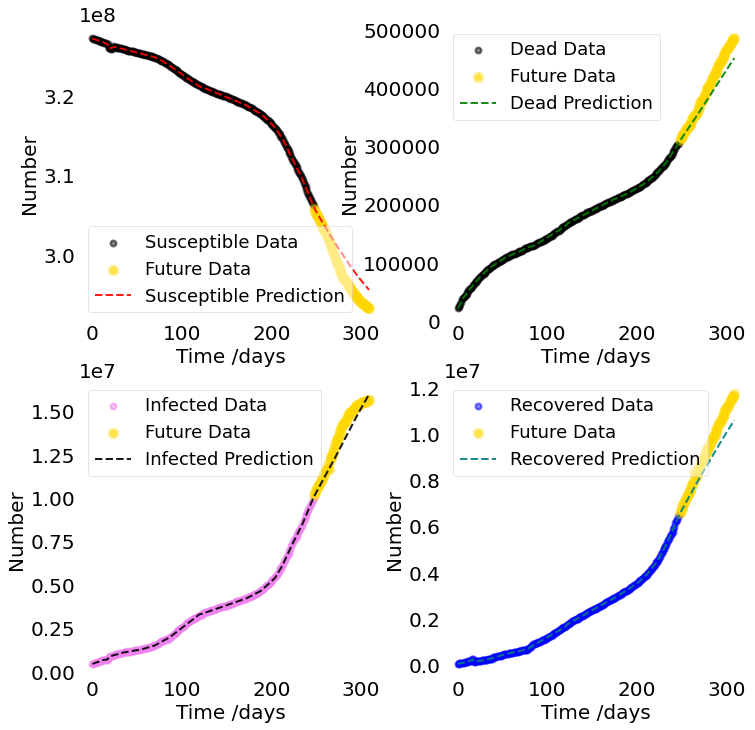

In [8]:
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

fig, ax = plt.subplots(2, 2, figsize = (12,12))


ax[0, 0].set_facecolor('xkcd:white')
ax[1, 0].set_facecolor('xkcd:white')
ax[0, 1].set_facecolor('xkcd:white')
ax[1, 1].set_facecolor('xkcd:white')


ax[0, 0].scatter(timesteps[:trainsize], cumulative_susceptible[:trainsize], c = 'black', alpha=0.5, lw=2, label='Susceptible Data')
ax[0, 0].scatter(timesteps[trainsize:], cumulative_susceptible[trainsize:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[0, 0].plot(timesteps, S_pred_list[0].detach().numpy(), 'red', alpha=0.9, lw=2, label='Susceptible Prediction', linestyle='dashed')

ax[1, 0].scatter(timesteps[:trainsize], cumulative_infected[:trainsize], c = 'violet', alpha=0.5, lw=2, label='Infected Data')
ax[1, 0].scatter(timesteps[trainsize:], cumulative_infected[trainsize:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[1, 0].plot(timesteps, I_pred_list[0].detach().numpy(), 'black', alpha=0.9, lw=2, label='Infected Prediction', linestyle='dashed')

ax[0, 1].scatter(timesteps[:trainsize], cumulative_dead[:trainsize], c = 'black', alpha=0.5, lw=2, label='Dead Data')
ax[0, 1].scatter(timesteps[trainsize:], cumulative_dead[trainsize:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[0, 1].plot(timesteps, D_pred_list[0].detach().numpy(), 'green', alpha=0.9, lw=2, label='Dead Prediction', linestyle='dashed')

ax[1, 1].scatter(timesteps[:trainsize], cumulative_recovered[:trainsize], c = 'blue', alpha=0.5, lw=2, label='Recovered Data')
ax[1, 1].scatter(timesteps[trainsize:], cumulative_recovered[trainsize:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[1, 1].plot(timesteps, R_pred_list[0].detach().numpy(), 'teal', alpha=0.9, lw=2, label='Recovered Prediction', linestyle='dashed')

ax[0, 0].set_xlabel('Time /days',size = 20)
ax[0, 0].set_ylabel('Number',size = 20)
ax[0, 0].yaxis.set_tick_params(length=0)
ax[0, 0].xaxis.set_tick_params(length=0)
# ax[0, 0].grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax[0, 0].legend(prop={'size':18})
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax[0, 0].spines[spine].set_visible(False)
############################################################
ax[1, 0].set_xlabel('Time /days',size = 20)
ax[1, 0].set_ylabel('Number',size = 20)
ax[1, 0].yaxis.set_tick_params(length=0)
ax[1, 0].xaxis.set_tick_params(length=0)
# ax[1, 0].grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax[1, 0].legend(prop={'size':18})
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax[1, 0].spines[spine].set_visible(False)
############################################################
ax[0, 1].set_xlabel('Time /days',size = 20)
ax[0, 1].set_ylabel('Number',size = 20)
ax[0, 1].yaxis.set_tick_params(length=0)
ax[0, 1].xaxis.set_tick_params(length=0)
# ax[0, 1].grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax[0, 1].legend(prop={'size':18})
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax[0, 1].spines[spine].set_visible(False)
############################################################
ax[1, 1].set_xlabel('Time /days',size = 20)
ax[1, 1].set_ylabel('Number',size = 20)
ax[1, 1].yaxis.set_tick_params(length=0)
ax[1, 1].xaxis.set_tick_params(length=0)
# ax[1, 1].grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax[1,1].legend(prop={'size':18})
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax[1,1].spines[spine].set_visible(False)
############################################################
# plt.savefig('covid_real_data_cumulative_cases.pdf')
plt.show()

In [9]:
print('dinn.alpha', dinn.alpha)
print('dinn.beta', dinn.beta)
print('dinn.gamma', dinn.gamma)

dinn.alpha tensor([0.0224], grad_fn=<TanhBackward>)
dinn.beta tensor([0.0082], grad_fn=<TanhBackward>)
dinn.gamma tensor([0.0002], grad_fn=<TanhBackward>)
